In [1]:
!pip install fastbook

     |████████████████████████████████| 727kB 2.8MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 194kB 14.3MB/s 
     |████████████████████████████████| 1.1MB 14.8MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 40kB 4.9MB/s 
     |████████████████████████████████| 92kB 8.3MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 2.6MB 19.7MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
from fastai.vision.all import *
from fastbook import *


Now we will work on the entire 10 digits

In [3]:
path = untar_data(URLs.MNIST)

In [4]:
Path.BASE_PATH = path

In [5]:
path.ls()

(#2) [Path('testing'),Path('training')]

In [6]:
def get_dls(bs=64):
  return DataBlock(
      blocks=(ImageBlock(cls= PILImageBW), CategoryBlock ),
      get_items=get_image_files,
      splitter= GrandparentSplitter('training', 'testing'),
      get_y = parent_label,
      batch_tfms = Normalize()
  ).dataloaders(path, bs=bs)

dls = get_dls()

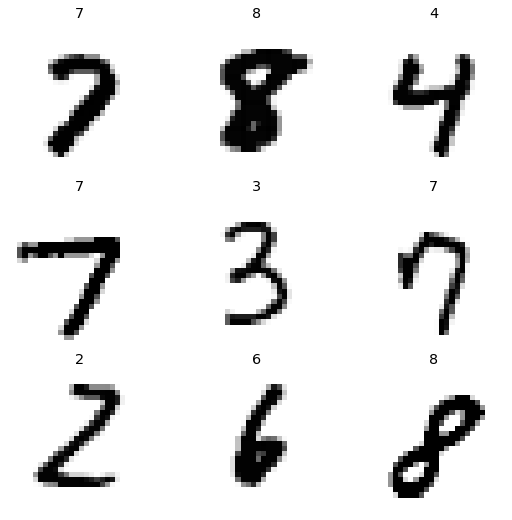

In [7]:
dls.show_batch()

In [8]:
# a basic convolution model looks like this
def conv(ni, nf, ks=3, act=True):
  res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
  if act: res = nn.Sequential(res, nn.ReLU())
  return res

In [9]:
def simple_cnn():
  return sequential(
      conv(1,8, ks=5),
      conv(8,16),
      conv(16,32),
      conv(32,64),
      conv(64,10, act=False),
      Flatten(),
  )

In [10]:
from fastai.callback.hook import *

In [11]:
def fit(epochs=1):
  learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy, metrics=accuracy, cbs=ActivationStats(with_hist=True))
  learn.fit(epochs, 0.06)
  return learn

In [12]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.750169,0.661008,0.784300,01:18


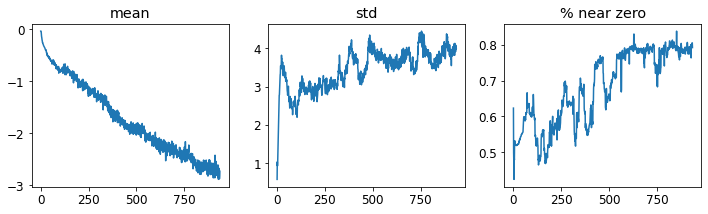

In [13]:
learn.activation_stats.plot_layer_stats(0)

# this indicates that all is not wellthere are a lot of zeros

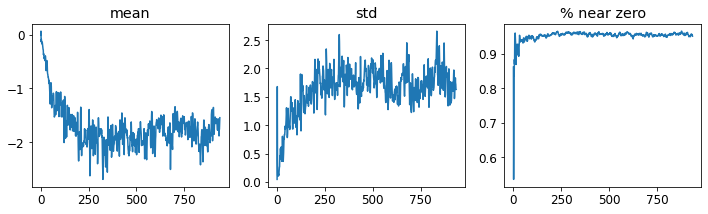

In [14]:
# when it reaches the final layers the zeros overwhelms 

learn.activation_stats.plot_layer_stats(-2)

how to solve this problem ?

### Increase batch size

In [15]:
dls = get_dls(512)
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.423129,0.257475,0.918400,01:03


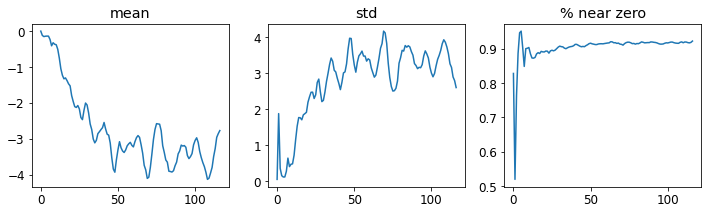

In [16]:
learn.activation_stats.plot_layer_stats(-2)
# not good enough again

### 1 cycle training

Our initial weights are not well suited to the task we're trying to solve. Therefore, it is dangerous to begin training with a high learning rate: we may very well make the training diverge instantly, as we've seen. We probably don't want to end training with a high learning rate either, so that we don't skip over a minimum. But we want to train at a high learning rate for the rest of the training period, because we'll be able to train more quickly that way. Therefore, we should change the learning rate during training, from low, to high, and then back to low again.

In [19]:
def fit(epochs=1, lr=0.06):
  learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy, metrics=accuracy, cbs=ActivationStats(with_hist=True))
  learn.fit_one_cycle(epochs, lr)
  return learn

In [20]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.203884,0.073272,0.976900,01:07


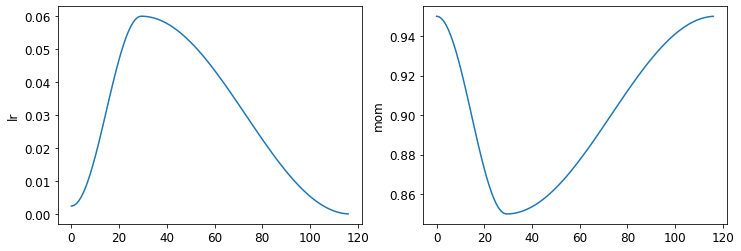

In [21]:
learn.recorder.plot_sched()

fit_one_cycle provides the following parameters you can adjust:

lr_max:: The highest learning rate that will be used (this can also be a list of learning rates for each layer group, or a Python slice object containing the first and last layer group learning rates)
div:: How much to divide lr_max by to get the starting learning rate
div_final:: How much to divide lr_max by to get the ending learning rate
pct_start:: What percentage of the batches to use for the warmup
moms:: A tuple (mom1,mom2,mom3) where mom1 is the initial momentum, mom2 is the minimum momentum, and mom3 is the final momentum

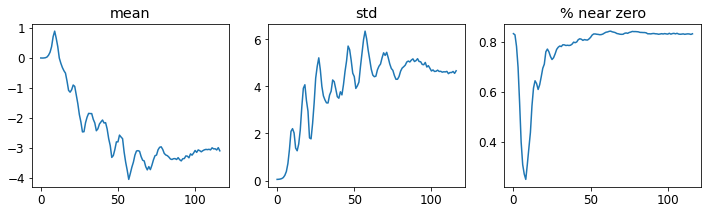

In [22]:
learn.activation_stats.plot_layer_stats(-2)

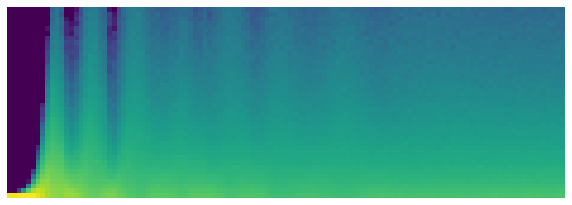

In [23]:
learn.activation_stats.color_dim(-2)

## Batch Normalisation

 After normalizing the activations to get some new activation vector y, a batchnorm layer returns gamma*y + beta.

In [24]:
def conv(ni, nf, ks=3, act=True):
  layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
  layers.append(nn.BatchNorm2d(nf))
  if act : layers.append(nn.ReLU())
  return nn.Sequential(*layers)

In [25]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.129835,0.055561,0.985800,01:12


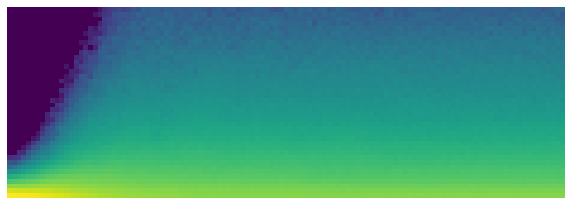

In [26]:
learn.activation_stats.color_dim(-4)

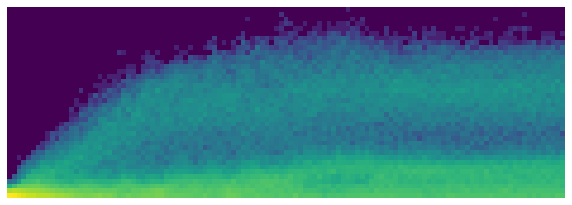

In [27]:
learn.activation_stats.color_dim(-2)

In [28]:
learn = fit(5, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.188536,0.213593,0.930500,01:15
1,0.083115,0.083344,0.974500,01:12
2,0.053018,0.064313,0.980100,01:14
3,0.034533,0.032303,0.990000,01:11
4,0.016999,0.025421,0.991700,01:11


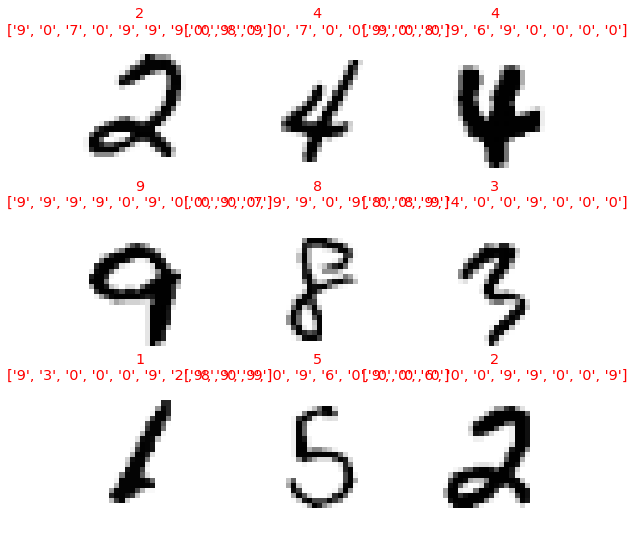

In [29]:
learn.show_results()

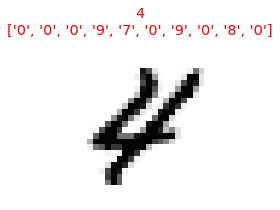

In [31]:
learn.show_results(max_n=1)

In [32]:
learn.export()